In [1]:
%matplotlib ipympl

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import circmean, circvar
from matplotlib.animation import FuncAnimation

import seaborn as sns

from matplotlib import rc
import yaml
import os

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5') # conda create -n newenv -c conda-forge ffmpeg

with open("cal-settings.yml", 'r') as file:
    vars = yaml.safe_load(file)
    RX_TX_SAME_CHANNEL = vars["RX_TX_SAME_CHANNEL"]

print("Cable connections")
if RX_TX_SAME_CHANNEL:
    REF_RX_CH = FREE_TX_CH = 0
    LOOPBACK_RX_CH = LOOPBACK_TX_CH = 1
    print("\nPLL REF-->CH0 RX\nCH1 TX-->CH1 RX\nCH0 TX -->")
else:
    LOOPBACK_RX_CH = FREE_TX_CH = 0
    REF_RX_CH = LOOPBACK_TX_CH = 1
    print("\nPLL REF-->CH1 RX\nCH1 TX-->CH0 RX\nCH0 TX -->")

loopback_rx_chs = [f"rx_ch{LOOPBACK_RX_CH}_df1", f"rx_ch{LOOPBACK_RX_CH}_df2"]
pll_rx_chs = [f"rx_ch{REF_RX_CH}_df1", f"rx_ch{REF_RX_CH}_df2"] 

Cable connections

PLL REF-->CH1 RX
CH1 TX-->CH0 RX
CH0 TX -->


In [2]:
timestamp = "20240529154227" # "20240529120223" 

usrp1_file = f'data_T01_{timestamp}.txt'

usrp2_file = f'data_T04_{timestamp}.txt'
scope_file = f'data_scope_{timestamp}.txt'

In [3]:
# wrap around function which "glues" together 0 and 360 degrees.

def wraparound(arr):
    arr = np.asarray(arr)
    fltr = arr > 180
    arr[fltr] = arr[fltr] - 360
    return arr

In [4]:
df = pd.read_csv(scope_file, names=[
                 "meas_id", "phase_diff", "phase_diff_13", "phase_diff_23"], header=None, sep=r'\s+') 

# should be close to zero
# print(df["phase_diff"] - (df["phase_diff_13"]- df["phase_diff_23"]))

print(df.head())

df.loc[(df['phase_diff'] < 180), 'phase_diff'] = df['phase_diff'].add(360)

df['phase_diff'] -= 360

fields = ["meas_id", "hostname", "meas_type",
          "tx_ch0", "tx_ch1", "rx_ch0", "rx_ch1", "_0", "_1"]

df1 = pd.read_csv(usrp1_file,
                  names=fields, header=None, sep=';')

df2 = pd.read_csv(usrp2_file,
                  names=fields, header=None, sep=';')


# given that we meanly want to plot things, shift the radians to degrees and wrap around
for frame in [df1, df2]:
    for col in ["tx_ch0", "tx_ch1", "rx_ch0", "rx_ch1"]:
        frame.loc[:, col] = wraparound(np.rad2deg(frame[col]))
        


# merge the two dataframes and include the phase diff
merged_df = pd.merge(df1, df2, on=['meas_id', "meas_type"], how='outer',
                     suffixes=('_df1', '_df2'))

merged_df["phase_diff"] = None

# Iterate over rows
for index, row in df.iterrows():
    merged_df.loc[merged_df['meas_id'] ==
                  row['meas_id'], "phase_diff"] = row["phase_diff"]
    


# clean up
df1.drop(columns=["_0", "_1"], inplace=True)
df2.drop(columns=["_0", "_1"], inplace=True)


fltr_pllck = merged_df['meas_type'] == "PLLCK"
fltr_lbck = merged_df['meas_type'] == "LBCK"
fltr_pll = merged_df['meas_type'] == "PLL"
fltr_lb = merged_df['meas_type'] == "LB"

   meas_id  phase_diff  phase_diff_13  phase_diff_23
0        1  340.159389     203.616885     223.678188
1        2   19.920634     228.240903     208.281285
2        3  344.775184     218.097428     233.284725
3        4   12.748241     215.176545     202.816322
4        5    9.493638     234.349972     225.435341


Mean: 2.17°
circ mean: 3.20°
circ var: 0.97°


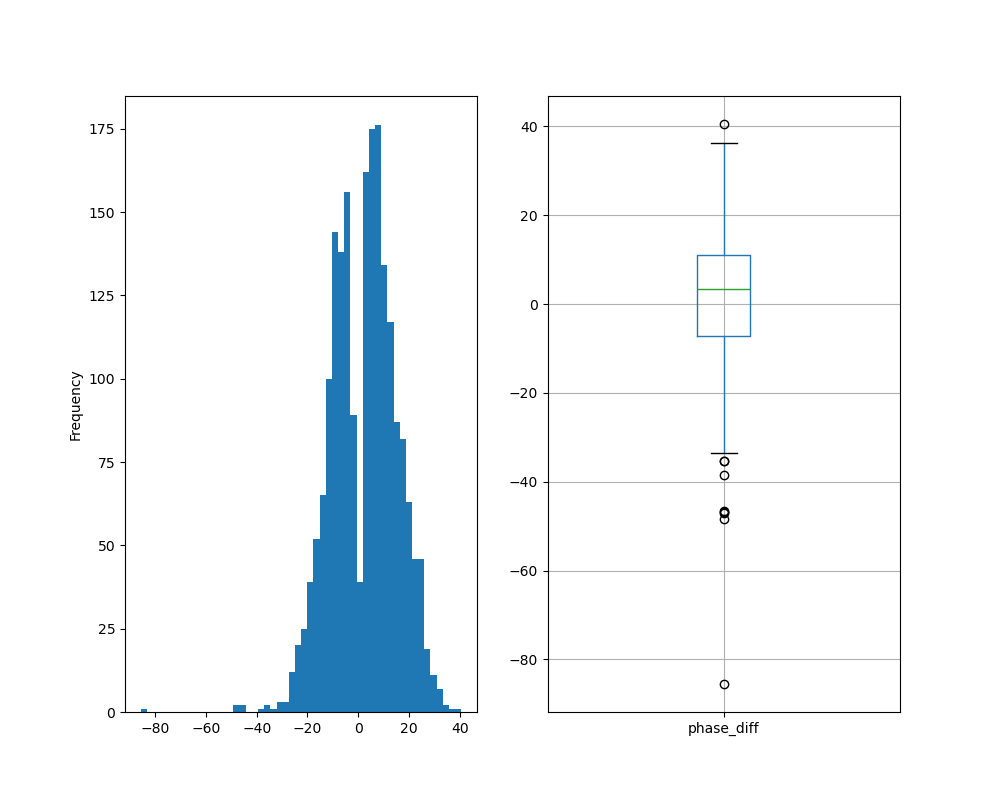

In [5]:
# plot hist and boxplot of the phase difffernce measured by the scope
df.loc[:, 'phase_diff'] = wraparound(df['phase_diff'])

fig, axes = plt.subplots(nrows=1, ncols=2)
df["phase_diff"].plot.hist(figsize=(10, 8), ax=axes[0], bins=52)
df.boxplot(column=['phase_diff'], ax=axes[1])

print(f"Mean: {np.mean(df['phase_diff']):.2f}°")
print(f"circ mean: {circmean(df['phase_diff']):.2f}°")
print(f"circ var: {circvar(df['phase_diff']):.2f}°")

Mean 13: 217.94°
circ mean 13: 2.71°
circ var 13: 0.94°
Mean 23: 215.23°
circ mean 23: 2.55°
circ var 23: 0.94°


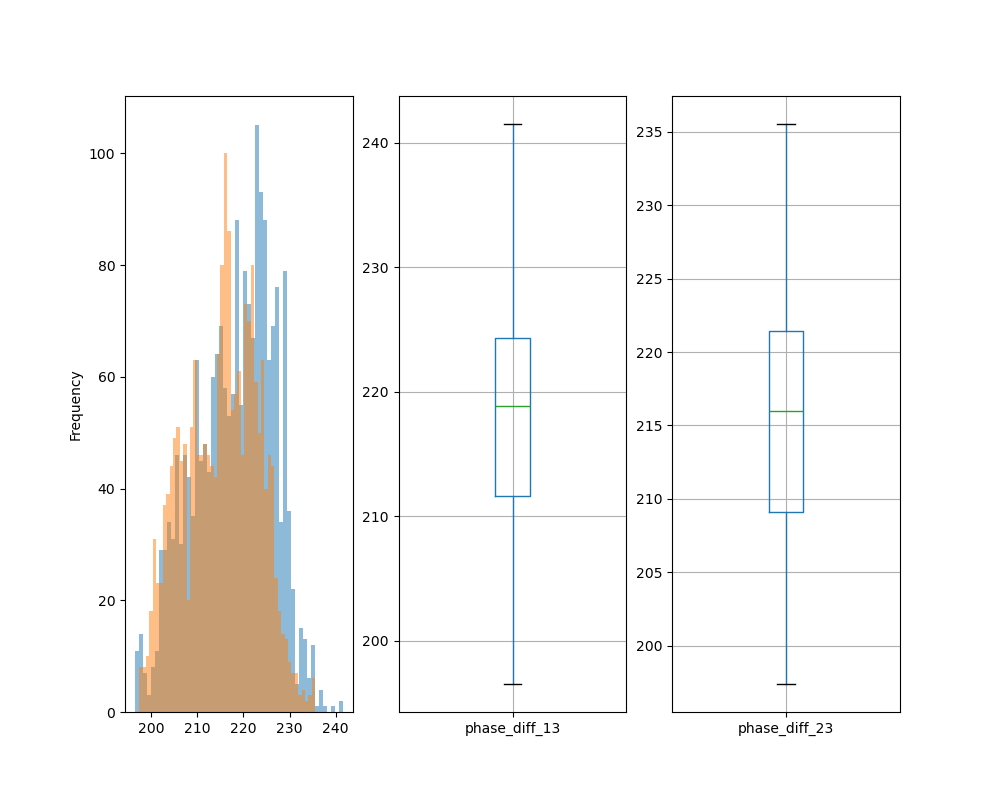

In [6]:
# plot hist and boxplot of the phase difffernce measured by the scope
df.loc[:, 'phase_diff'] = wraparound(df['phase_diff'])

fig, axes = plt.subplots(nrows=1, ncols=3)
df["phase_diff_13"].plot.hist(figsize=(10, 8), ax=axes[0], bins=52, alpha=0.5)
df.boxplot(column=['phase_diff_13'], ax=axes[1])

print(f"Mean 13: {np.mean(df['phase_diff_13']):.2f}°")
print(f"circ mean 13: {circmean(df['phase_diff_13']):.2f}°")
print(f"circ var 13: {circvar(df['phase_diff_13']):.2f}°")

df["phase_diff_23"].plot.hist(figsize=(10, 8), ax=axes[0], bins=52, alpha=0.5)
df.boxplot(column=['phase_diff_23'], ax=axes[2])

print(f"Mean 23: {np.mean(df['phase_diff_23']):.2f}°")
print(f"circ mean 23: {circmean(df['phase_diff_23']):.2f}°")
print(f"circ var 23: {circvar(df['phase_diff_23']):.2f}°")

Check the absolute measured loopback check per USRP. This means read the measured phase after the first phase calibration (i.e., transmitting with $-(\phi_{rx}+\phi_{tx})$).

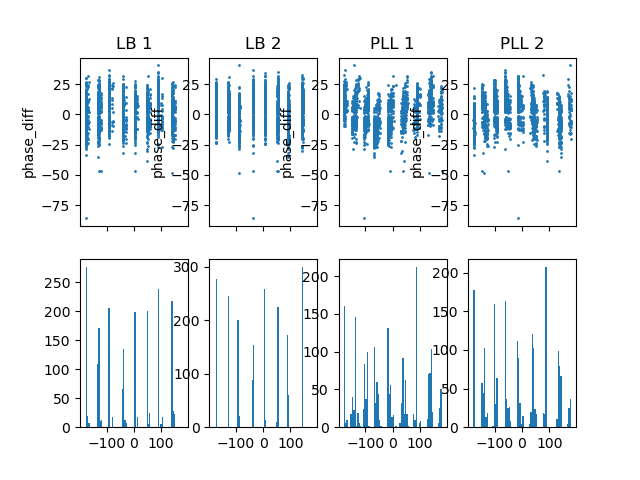

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True)

resolution = 5

for i, (loopback_rx, pll_rx) in enumerate(zip(loopback_rx_chs, pll_rx_chs)):
    merged_df.where(fltr_lb).plot.scatter(
        x=loopback_rx, y='phase_diff', title=f"LB {i+1}", ax=axes[0, i], s=1)
    merged_df.where(fltr_pll).plot.scatter(
        x=pll_rx, y='phase_diff', title=f"PLL {i+1}", ax=axes[0, i+2], s=1)
        
    x_df = merged_df.where(fltr_lb).loc[:, loopback_rx].values
    axes[1, i].hist(x_df, bins=360//resolution)

    x_df = merged_df.where(fltr_pll).loc[:, pll_rx].values
    axes[1, i+2].hist(x_df, bins=360//resolution)

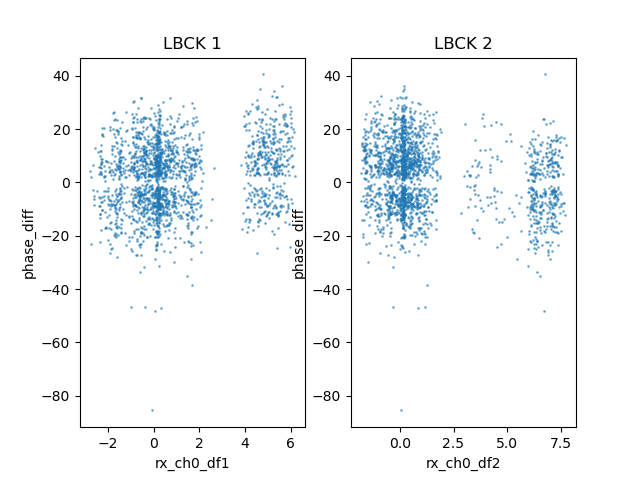

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for i, loopback_rx in enumerate(loopback_rx_chs):
    merged_df.where(merged_df['meas_type'] == "LBCK").plot.scatter(x=loopback_rx,
                                                                y='phase_diff', title=f"LBCK {i+1}", ax=axes[i], s=1, alpha=0.5);

<Axes: title={'center': 'PLLCK 2'}, xlabel='PLLCK_CH0-CH1_add', ylabel='phase_diff'>

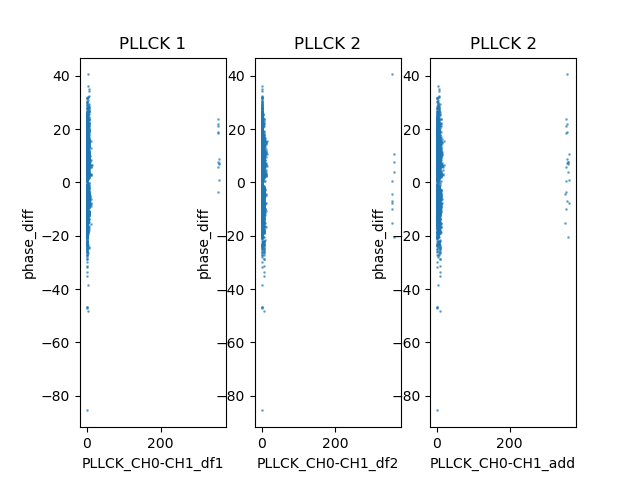

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3)
merged_df.loc[fltr_pllck, "PLLCK_CH0-CH1_df1"] = np.abs(merged_df.loc[fltr_pllck, loopback_rx_chs[0]] - merged_df.loc[fltr_pllck, pll_rx_chs[0]])
merged_df.loc[fltr_pllck, "PLLCK_CH0-CH1_df2"] = np.abs(merged_df.loc[fltr_pllck, loopback_rx_chs[1]] - merged_df.loc[fltr_pllck, pll_rx_chs[1]])

merged_df.where(fltr_pllck).plot.scatter(x="PLLCK_CH0-CH1_df1",y='phase_diff', title=f"PLLCK {1}", ax=axes[0], s=1, alpha=0.5)
merged_df.where(fltr_pllck).plot.scatter(x="PLLCK_CH0-CH1_df2",y='phase_diff', title=f"PLLCK {2}", ax=axes[1], s=1, alpha=0.5)


merged_df.loc[fltr_pllck,
              "PLLCK_CH0-CH1_add"] = merged_df.loc[fltr_pllck, "PLLCK_CH0-CH1_df1"]+merged_df.loc[fltr_pllck, "PLLCK_CH0-CH1_df2"]

merged_df.where(fltr_pllck).plot.scatter(x="PLLCK_CH0-CH1_add",
                                         y='phase_diff', title=f"PLLCK {2}", ax=axes[2], s=1, alpha=0.5)

Check the accumalated absolute measured loopback check of both USRP.

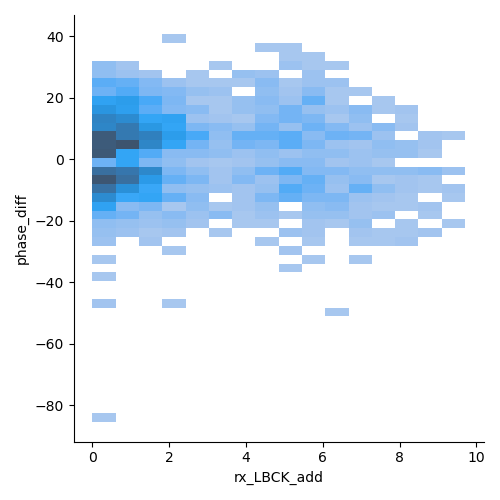

In [10]:
fltr = merged_df['meas_type'] == "LBCK"

merged_df.loc[fltr, 'rx_LBCK_add'] = np.abs(merged_df.loc[fltr, loopback_rx_chs[0]] - merged_df.loc[fltr, loopback_rx_chs[1]])

sns.displot(merged_df, x="rx_LBCK_add", y="phase_diff")

In the following, I am investigating the phase difference when measuring the PLL phase, i.e.,
$$\phi_1 = \phi_{pll}+\phi_{rx, 1}$$
$$\phi_2 = \phi_{pll}+\phi_{rx, 2}$$

I would suspect that due to the dividers in the USRP, $\phi_1$ and $\phi_2$ would overlap when the RX PLLs of both USRPs were aligned (and the received PLL phases are by design aligned). Additionally, 8 clusters of phases should be visible due to the dividers (3 dividers = 2^3 possible phase rotations).

However, we observe that this is not the case and additional, but fixed (in time and power cycle) phase difference between the clusters is observed.

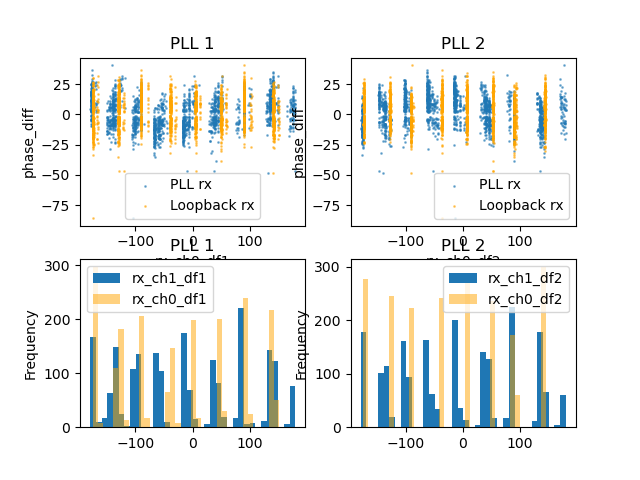

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for i, (pll_rx, loopback_rx) in enumerate(zip(pll_rx_chs, loopback_rx_chs)):
    merged_df.where(merged_df['meas_type'] == "PLL").plot.scatter(x=pll_rx,
                                                                 y='phase_diff', title=f"PLL {i+1}", ax=axes[0,i], s=1, alpha=0.5, label="PLL rx")
    merged_df.where(merged_df['meas_type'] == "LB").plot.scatter(x=loopback_rx,
                                                                  y='phase_diff', title=f"PLL {i+1}", ax=axes[0,i], s=1, alpha=0.5, c="orange", label="Loopback rx" )

    merged_df.where(merged_df['meas_type'] == "PLL").plot.hist(
        column=pll_rx, title=f"PLL {i+1}", ax=axes[1, i], bins=360//10, label="PLL rx")
    merged_df.where(merged_df['meas_type'] == "LB").plot.hist(
        column=loopback_rx, title=f"PLL {i+1}", ax=axes[1, i], bins=360//10, color="orange", label="Loopback rx", alpha=0.5)


plt.legend();

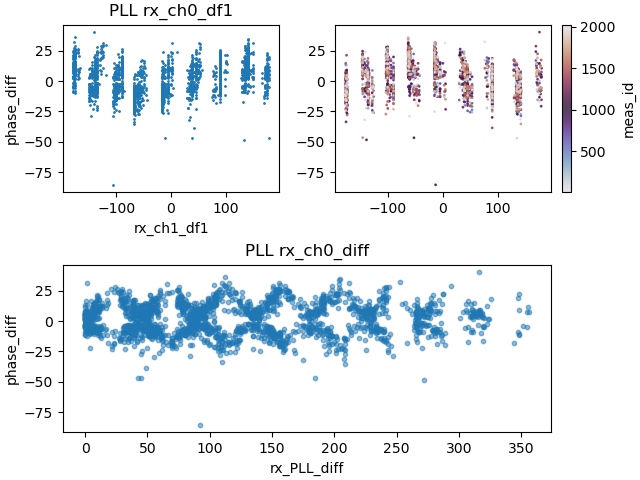

0.1699555994079921
0        64.832438
1        66.117069
2        66.179548
3        66.204624
4       166.875276
           ...    
8103    120.055055
8104    190.124376
8105    187.956473
8106    188.880660
8107    188.896330
Name: rx_PLL_diff, Length: 8108, dtype: float64


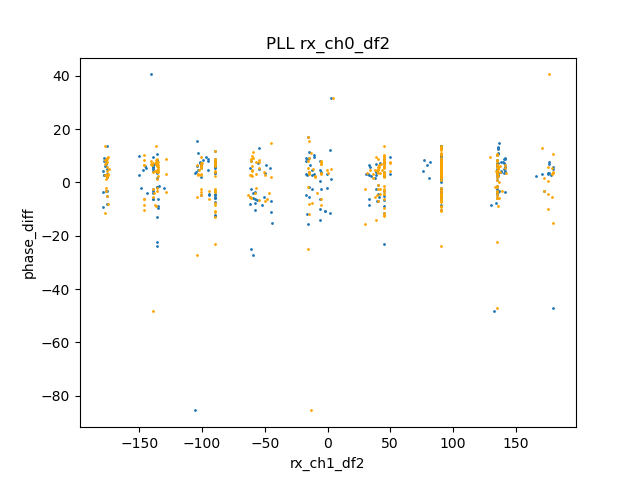

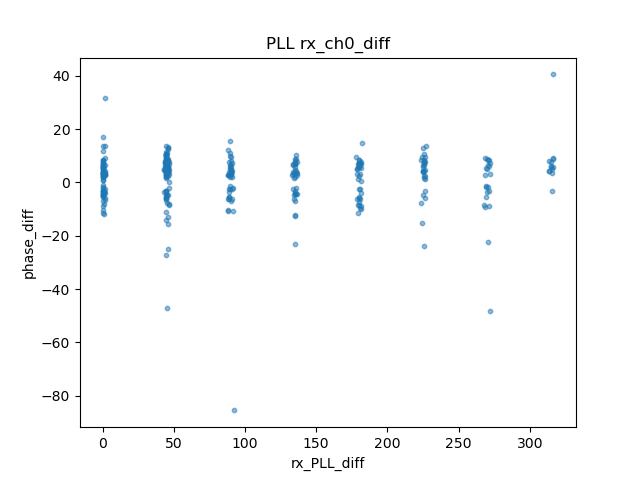

In [12]:
merged_df["rx_PLL_diff"] = np.abs(merged_df[pll_rx_chs[0]] - merged_df[pll_rx_chs[1]])

fig, axd = plt.subplot_mosaic([['left', 'right'], ['bottom', 'bottom']], constrained_layout=True)

merged_df.where(merged_df['meas_type'] == "PLL").plot.scatter(x=pll_rx_chs[0],y='phase_diff', title="PLL rx_ch0_df1", ax=axd['left'], s=1)

pll_df = merged_df[merged_df['meas_type'] == 'PLL']

sc = axd['right'].scatter(pll_df[pll_rx_chs[1]], pll_df['phase_diff'], c=pll_df['meas_id'], cmap='twilight', alpha=0.8, s=1)

plt.colorbar(sc, label='meas_id')

merged_df.where(fltr_pll).plot.scatter(x='rx_PLL_diff',
                                       y='phase_diff', title="PLL rx_ch0_diff", ax=axd['bottom'], alpha =0.5, s=10)

plt.show()

# Define a function to check if a number is within 5 of a multiple of 45


def is_within_5_of_multiple_of_45(x):
    return (x % 45 <= 2) or (x % 45 >= 43)

# Select rows where 'rx_PLL_diff' is a multiple of 45
fltr_45 = merged_df['rx_PLL_diff'].apply(is_within_5_of_multiple_of_45)
print(sum(fltr_45)/len(fltr_45))
print(merged_df['rx_PLL_diff'])
filtered_df = merged_df[fltr_45]
ax = filtered_df.where(fltr_pll).plot.scatter(
    x=pll_rx_chs[0], y='phase_diff', title="PLL rx_ch0_df1", s=1)
filtered_df.where(fltr_pll).plot.scatter(
    x=pll_rx_chs[1], y='phase_diff', title="PLL rx_ch0_df2", s=1, ax=ax, c="orange")
plt.show()

filtered_df.where(fltr_pll).plot.scatter(x='rx_PLL_diff',
                                       y='phase_diff', title="PLL rx_ch0_diff", alpha=0.5, s=10)
plt.show()

Cluster centers:
 [ -96.39228771   89.41066533  -11.35772305 -176.1917132   146.54396219
   40.6723385  -139.06474187  -60.65794924]
Cluster labels:
 [2 6 7 ... 6 6 6]
Cluster centers:
 [-176.1917132  -139.06474187  -96.39228771  -60.65794924  -11.35772305
   40.6723385    89.41066533  146.54396219]
[37.12697133252567, 42.67245415277482, 35.734338470689174, 49.300226190920625, 52.03006155084778, 48.73832683158325, 57.13329685720605]
Cluster centers:
 [ -57.69606386  144.64062431 -175.85561023   41.95348025 -138.45052629
  -11.66405761   88.64565522  -97.72485474]
Cluster labels:
 [3 3 2 ... 0 5 3]
Cluster median:
 {0: -60.4444580284279, 1: 137.5940497906582, 2: -175.52795575270284, 3: 40.518896316664595, 4: -137.31026993566783, 5: -13.855197058278122, 6: 89.99495930095733, 7: -100.58651140886795}
Cluster centers:
 [-175.85561023 -138.45052629  -97.72485474  -57.69606386  -11.66405761
   41.95348025   88.64565522  144.64062431]
[37.40508394233615, 40.725671543449224, 40.02879088604321, 

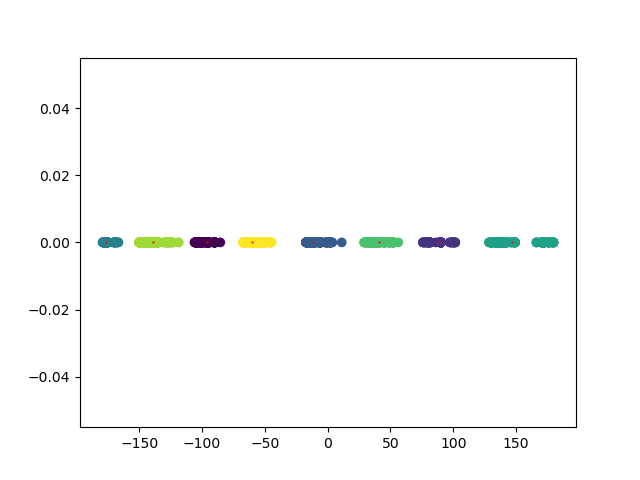

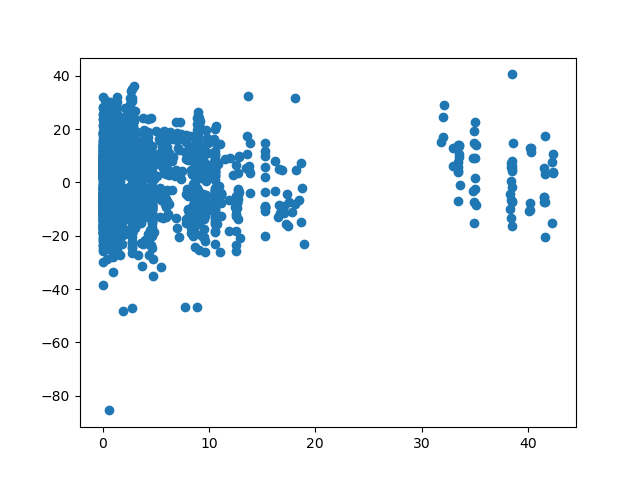

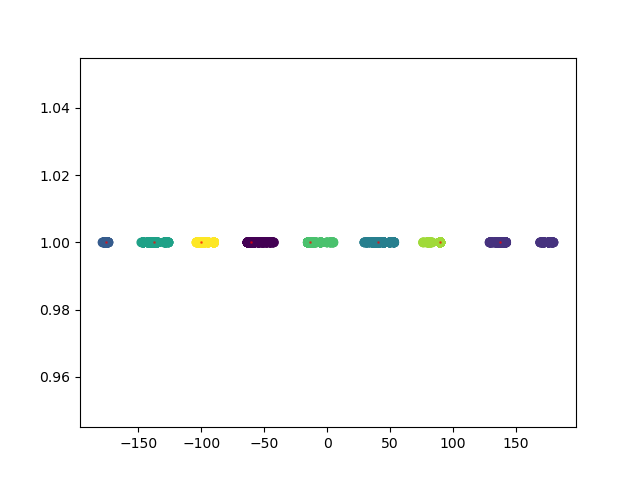

In [13]:

from sklearn.cluster import KMeans

num_clusters = 8

ax = sns.histplot(
    data=merged_df.loc[fltr_pll, :], x=pll_rx_chs[0], bins=52, kde=True)
sns.histplot(data=merged_df.loc[fltr_pll, :],
             x=pll_rx_chs[1], ax=ax, bins=52, kde=True)


array = merged_df.loc[fltr_pll, pll_rx_chs[0]].values
phase_diffs = merged_df.loc[fltr_pll, "phase_diff"].values

# Reshape array for KMeans
array_reshaped = array.reshape(-1, 1)

# Apply KMeans with 8 clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(array_reshaped)

# Get the cluster labels
labels = kmeans.labels_

# Get the cluster centers
centers = kmeans.cluster_centers_.flatten()

# Print the results
print("Cluster centers:\n", centers)
print("Cluster labels:\n", labels)

sorted_clusters = np.sort(centers)
print("Cluster centers:\n", sorted_clusters)
differences = [sorted_clusters[i + 1] - sorted_clusters[i]
               for i in range(len(sorted_clusters) - 1)]
print(differences)


plt.figure()
# Optional: Visualize the clusters
plt.scatter(array, np.zeros_like(array), c=labels, cmap='viridis')
plt.scatter(centers, np.zeros_like(centers), c='red', s=1, alpha=0.5)


array = merged_df.loc[fltr_pll, pll_rx_chs[1]].values

# Reshape array for KMeans
array_reshaped = array.reshape(-1, 1)

# Apply KMeans with 8 clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(array_reshaped)

# Get the cluster labels
labels = kmeans.labels_

# Get the cluster centers
centers = kmeans.cluster_centers_.flatten()

# Print the results
print("Cluster centers:\n", centers)
print("Cluster labels:\n", labels)

# Group elements by their cluster labels
clusters = {i: array[labels == i] for i in range(num_clusters)}

# Compute average value per cluster
cluster_median = {i: np.median(cluster) for i, cluster in clusters.items()}
print("Cluster median:\n", cluster_median)


absolute_differences = [x for i in range(num_clusters) for x in np.abs(
    array[labels == i] - cluster_median[i])]
phase_diffs_center_diff = [x for i in range(
    num_clusters) for x in phase_diffs[labels == i]]

plt.figure()
plt.scatter(absolute_differences, phase_diffs_center_diff)


sorted_clusters = np.sort(centers)
print("Cluster centers:\n", sorted_clusters)
differences = [sorted_clusters[i + 1] - sorted_clusters[i]
               for i in range(len(sorted_clusters) - 1)]
print(differences)

# Optional: Visualize the clusters
plt.figure()
plt.scatter(array, np.ones_like(array), c=labels, cmap='viridis')
plt.scatter(list(cluster_median.values()), np.ones_like(list(
    cluster_median.values())), c='red', s=1, alpha=0.5)

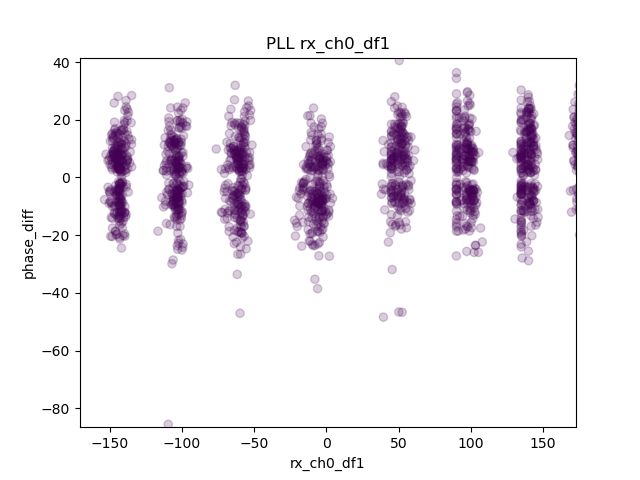

In [14]:

fig, ax = plt.subplots()
sc = ax.scatter([], [], c=[], cmap='viridis', alpha=0.2)
ax.set_xlim(pll_df['rx_ch0_df1'].min() - 1, pll_df['rx_ch0_df1'].max() + 1)
ax.set_ylim(pll_df['phase_diff'].min() - 1, pll_df['phase_diff'].max() + 1)
# plt.colorbar(sc, ax=ax, label='meas_id')
ax.set_title('PLL rx_ch0_df1')
ax.set_xlabel('rx_ch0_df1')
ax.set_ylabel('phase_diff')

# Step 3: Define the initialization function


def init():
    sc.set_offsets(np.empty((0, 2)))
    return sc,

# Step 4: Define the animation function


def animate(i):
    current_df = pll_df[pll_df['meas_id'] <= i]
    # current_df = current_df[current_df['meas_id'] > (i-200)]
    sc.set_offsets(current_df.loc[:, ['rx_ch0_df2', 'phase_diff']], )
    sc.set_array(current_df['meas_id'])
    # alphas = (current_df['meas_id'] / i).values
    # colors = np.zeros((len(current_df), 4))
    # colors[:, 0] = 1  # Set red color
    # colors[:, 3] = alphas  # Set alpha based on meas_id
    # sc.set_array(colors)
    return sc,


max_meas_id = int(pll_df['meas_id'].max())

# Step 5: Create the animation
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=np.arange(1, max_meas_id + 1, step=100), interval=400, blit=True)

anim

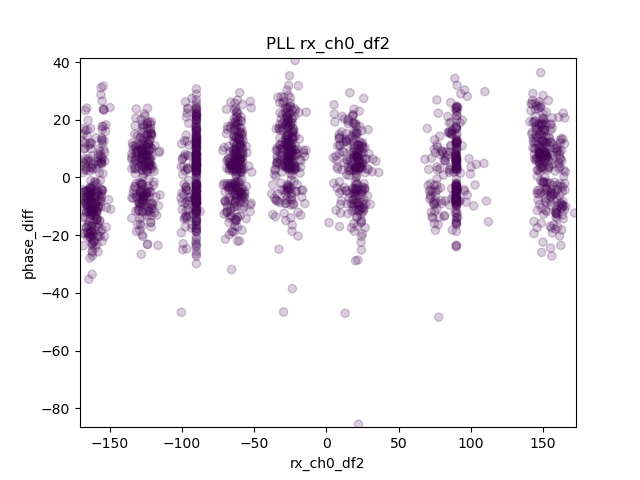

In [15]:
# Step 2: Create the plot
fig, ax = plt.subplots()
sc = ax.scatter([], [], c=[], cmap='viridis', alpha=0.2)
ax.set_xlim(pll_df['rx_ch0_df1'].min() - 1, pll_df['rx_ch0_df1'].max() + 1)
ax.set_ylim(pll_df['phase_diff'].min() - 1, pll_df['phase_diff'].max() + 1)
# plt.colorbar(sc, ax=ax, label='meas_id')
ax.set_title('PLL rx_ch0_df2')
ax.set_xlabel('rx_ch0_df2')
ax.set_ylabel('phase_diff')

# Step 3: Define the initialization function


def init():
    sc.set_offsets(np.empty((0, 2)))
    return sc,

# Step 4: Define the animation function


def animate(i):
    current_df = pll_df[pll_df['meas_id'] <= i]
    # current_df = current_df[current_df['meas_id'] > (i-200)]
    sc.set_offsets(current_df.loc[:,['rx_ch0_df1', 'phase_diff']], )
    sc.set_array(current_df['meas_id'])
    # alphas = (current_df['meas_id'] / i).values
    # colors = np.zeros((len(current_df), 4))
    # colors[:, 0] = 1  # Set red color
    # colors[:, 3] = alphas  # Set alpha based on meas_id
    # sc.set_array(colors)
    return sc,

max_meas_id = int(pll_df['meas_id'].max())

# Step 5: Create the animation
anim = FuncAnimation(fig, animate, init_func=init,
                    frames=np.arange(1,max_meas_id + 1,step=100), interval=400, blit=True)

anim

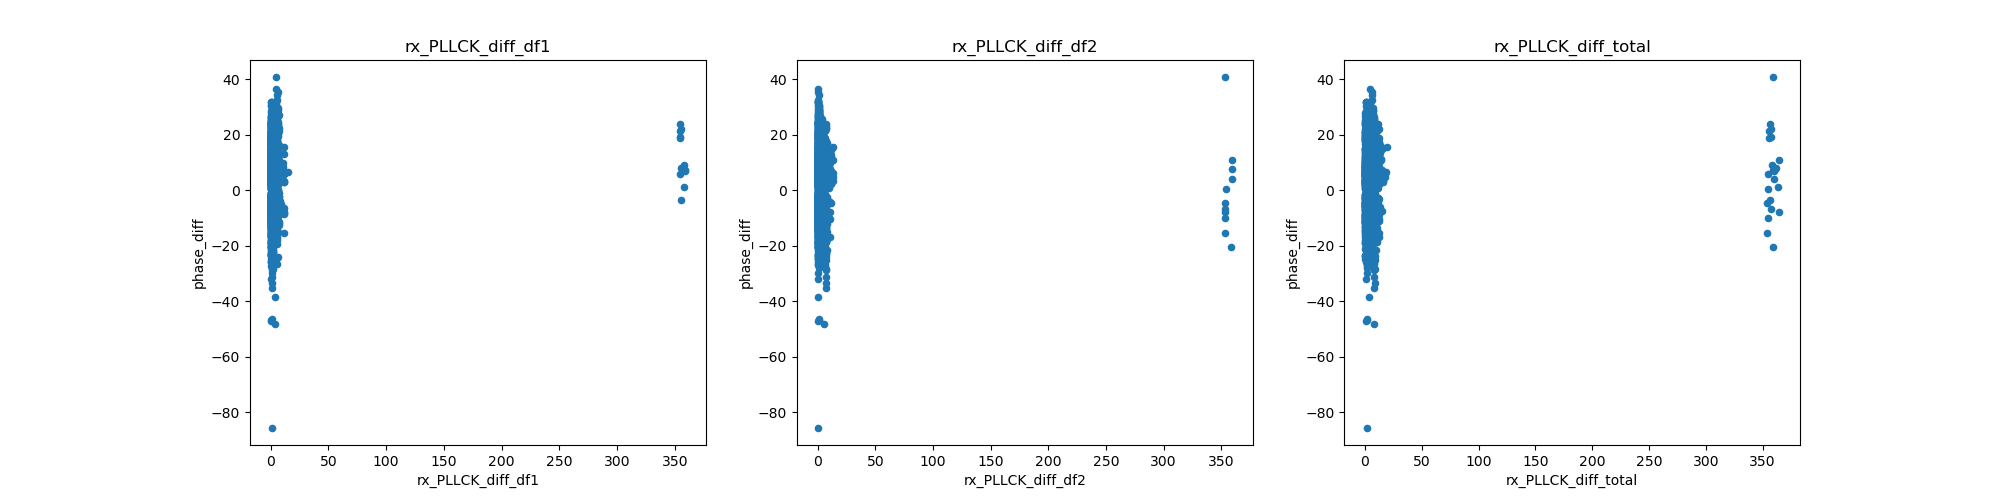

In [16]:
# PLLCK RX0 and RX1 should have approx the same value


fltr = merged_df['meas_type'] == "PLLCK"

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i in [1,2]:

    merged_df.loc[fltr, f'rx_PLLCK_diff_df{i}'] = np.abs(
        merged_df.loc[fltr, loopback_rx_chs[i-1]] - merged_df.loc[fltr, pll_rx_chs[i-1]])

    merged_df.plot.scatter(x=f'rx_PLLCK_diff_df{i}', y='phase_diff',
                           title=f'rx_PLLCK_diff_df{i}', ax=axes[i-1]);
merged_df.loc[fltr, f'rx_PLLCK_diff_total'] = merged_df.loc[fltr,
                                                            f'rx_PLLCK_diff_df1'] + merged_df.loc[fltr, f'rx_PLLCK_diff_df2']
merged_df.plot.scatter(x='rx_PLLCK_diff_total', y='phase_diff',
                       title='rx_PLLCK_diff_total', ax=axes[-1]);


In [17]:


x = (merged_df.loc[fltr_pllck, 'rx_PLLCK_diff_total'].values +
     merged_df.loc[fltr_lbck, 'rx_LBCK_add'].values)


plt.scatter(x, merged_df.loc[fltr_pllck, "phase_diff"].values)